In [2]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from itertools import chain
from keras import optimizers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from nltk.corpus import stopwords
import string
import nltk
from bs4 import BeautifulSoup
import regex as re
import random
import collections
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayrton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_fake = pd.read_csv('../data/Fake.csv', sep=',')
df_true = pd.read_csv('../data/True.csv', sep=',')

In [4]:
df_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [5]:
df_fake.subject[10:] 

10              News
11              News
12              News
13              News
14              News
            ...     
23476    Middle-east
23477    Middle-east
23478    Middle-east
23479    Middle-east
23480    Middle-east
Name: subject, Length: 23471, dtype: object

In [6]:
df_true.describe() # procesamiento del texto a revisar

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [7]:
df_fake["labels"] = 0
df_true["labels"] = 1

In [8]:
# print(df_true.subject.unique())
# print(df_fake.subject.unique())

df_concat = pd.concat([df_fake, df_true])

# one_hot = pd.get_dummies(df_concat['subject'])
# print(one_hot[:5])

In [9]:
df_concat['text'] = df_concat['title'] + " " + df_concat['text']

In [10]:
df_concat = df_concat[['text', 'labels']]

In [11]:
# Remover palabras que no aportan mucho 
# ej: articulos como The
# Inspirado por Madz2000 de Kaggle
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
print(stop)

{'and', 'during', 're', 'was', 'no', 'had', 'do', "aren't", '-', 'haven', 'all', 'its', 'few', 'y', 'our', "it's", 'own', 'at', 'to', '}', 'yourself', 'only', "mustn't", 'such', "needn't", 'above', 'against', 'd', 'any', '"', 'they', 'an', "you'll", 'won', "she's", 'about', 'down', 'wouldn', 'a', 've', 'most', "weren't", 'so', "you're", 'very', 'some', "mightn't", '_', 'will', '<', 'if', '?', 'have', 'aren', 'here', 'ourselves', 'from', 'he', 'can', "hasn't", 'before', 'other', '|', "doesn't", 'her', 'again', 'until', 'did', "haven't", '$', '\\', 'the', 'shan', 'but', 'them', 'doesn', "didn't", 'having', "hadn't", 'through', '+', '[', 'not', 'she', 'yours', 'or', 'wasn', 'ours', '#', 'between', 'then', 'that', "should've", 'off', 'been', 'than', 'whom', 'hadn', '`', 'further', '>', 'theirs', 'his', 'shouldn', "shan't", 'themselves', 'too', 'now', 'there', 'himself', 'on', 'm', 'didn', "wasn't", "that'll", 'him', 'needn', 'same', 'once', ')', 'these', 'after', 'which', 'don', 'couldn', 

In [12]:
# La data contiene tags de html ejemplo:
# <a href= https://www.yahoo.com/news/video-shows-guards-dragging-passenger-off-united-flight-132930349.html >Yahoo</a>
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_links(text):
    return re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_links(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = re.sub('href=((\"|\')(( ?)|(.+))(\"|\'))?', '', text)
    text = re.sub('\(@\w+\)', '', text)
    text = re.sub('\s\d+\s', '', text)
    text = text.replace("\"","")
    text = text.replace("'","")
    text = text.replace("“","")
    text = text.replace("”","")
    text = text.replace("“”","")
    text = text.replace("“ ”","")
    text = text.replace(",","")
    text = text.replace(".","")
    text = text.replace(")", "")
    text = text.replace("(", "")
    text = text.replace("()", "")
    text = text.replace("( )","")
    text = text.replace("?","")
    text = text.replace("¿","")
    text = text.replace("*","")
    text = text.replace("!","")
    text = text.replace("¡","")
    text = text.replace("‘","")
    text = text.replace("’","")
    text = text.replace("{","")
    text = text.replace("}","")
    text = text.replace(";","")
    text = text.replace("#","")
    text = text.replace("@","")
    text = text.replace("$","")
    #text = re.sub('(,)|"(.)|(\s([a-z]|[A-Z]|\d+|)\s)','',text)
    return text.lower()
#Apply function on review column
df_concat['text']=df_concat['text'].apply(denoise_text)

In [13]:
sentence = "asdfasdf"
denoise_text(sentence).strip()

'asdfasdf'

In [14]:
df_concat.sample(n=50).head(1).values

array([['fox airs footage riots covering president obamas black lives matter meeting video despicable bit biased news coverage fox friends aired footage riots covering president obama meeting black lives matter obama first lady michelle obama celebrated black history month white house thursday met several leaders black lives matter movement nearly two hours thanking efforts bring attention issues important african-american lives matter began peaceful protest police shootings unarmed black men women since become larger organization focused issues well including mass incarceration income news course cover event fairly all covering story conservative network aired footage black people rioting even though riots nothing heather childers introduced segment opening comments riots baltimore ferguson playing footage fox apparently keeps hand air whenever president obama dares honor anybody white violent riots several years ago ferguson baltimore drawing praise president obama praise childres sa

In [15]:
subject_freq_fake = df_fake.subject.value_counts()
subject_freq_true = df_true.subject.value_counts()

subject_freq_fake

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [16]:
subject_freq_true

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [17]:
#df_concat_title_text = list(chain.from_iterable(df_concat.text.str.split()))

def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_concat.text)

counter=collections.Counter(corpus)
#print(counter)

most_common = counter.most_common(10000)

In [18]:
df_concat_title_text = list(set(chain.from_iterable(df_concat.text.str.split())))

donald = 0
for i in df_concat_title_text:
    if i == 'Donald' or i =='donald':
        donald = donald + 1

print(donald)

1


In [19]:
df_concat_title_dic = {}

df_concat_title_dic['UNK'] = 10001

for i,(clave,_) in enumerate(most_common):
    df_concat_title_dic[clave] = i

In [20]:
def word_to_id(sentence):
    lista = sentence.split(' ')
    id_list = []
    for palabra in lista:
        if palabra not in df_concat_title_dic:
            id_list.append(df_concat_title_dic['UNK'])
        else:
            id_list.append(df_concat_title_dic[palabra])
    return id_list


In [21]:
def vectorize_sequences(sequences, dimension=10002):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results

df_concat.text = df_concat.text.apply(lambda x: vectorize_sequences([word_to_id(x)]))

In [22]:
df_concat.text = df_concat.text.apply(lambda x: x.squeeze())

In [23]:
df_concat.head(1).text.values[0].shape

(10002,)

In [24]:
y = df_concat["labels"]
y = np.asarray(y).astype(np.float32)
type(y)

numpy.ndarray

In [25]:
assert y.shape[0] == len(df_concat.index) 

In [26]:
df_concat.text.values.shape

(44898,)

In [27]:
a = []
for item in df_concat.text:
    a.append(item)
X = np.asarray(a).astype(np.float32)

In [28]:
X.dtype

dtype('float32')

In [29]:
y.dtype

dtype('float32')

In [30]:
assert X.shape[0] == y.shape[0]

In [31]:
### Crashea

In [32]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
# display(X_train.shape, X_val.shape, X_test.shape,  y_test.shape, y_val.shape, y_train.shape)

In [33]:
X_train.shape[0]

33673

In [34]:
model = Sequential()

model.add(Dense(16, activation="relu", input_shape=(X_train.shape[1],), name="hidden_layer_1"))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', name="hidden_layer_2"))
model.add(Dense(1, activation='sigmoid', name="output_layer_3"))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 16)                160048    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 16)                272       
_________________________________________________________________
output_layer_3 (Dense)       (None, 1)                 17        
Total params: 160,337
Trainable params: 160,337
Non-trainable params: 0
_________________________________________________________________


In [36]:
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [37]:
optimizer = optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')

callbacks_list=[early_stopping,reduce_lr,checkpoint]

In [39]:
# Entrenamos
history = model.fit(x=X_train, y=y_train,
                    epochs=20, callbacks=callbacks_list,batch_size=32, validation_data=(X_val, y_val)) 

Epoch 1/20
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0861 - accuracy: 0.9733 - val_loss: 0.0108 - val_accuracy: 0.9978
Epoch 2/20
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0142 - accuracy: 0.9952 - val_loss: 0.0133 - val_accuracy: 0.9972
Epoch 3/20
1045/1053 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9953
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0118 - accuracy: 0.9954 - val_loss: 0.0138 - val_accuracy: 0.9973
Epoch 4/20
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 0.0138 - val_accuracy: 0.9975
Epoch 5/20
1039/1053 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9969
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0069 - acc

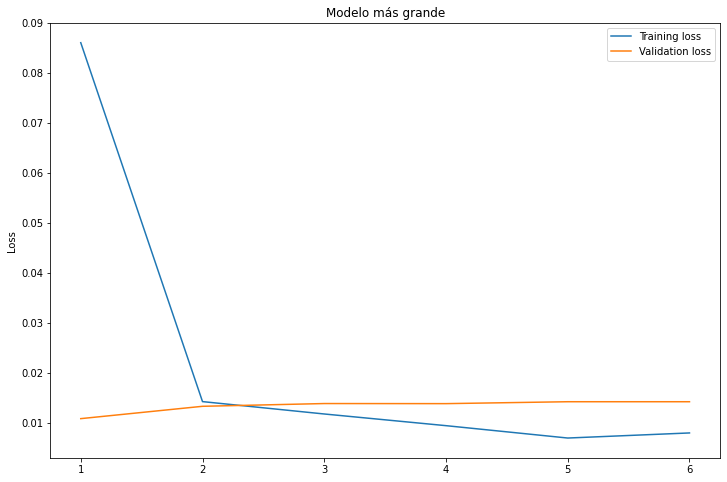

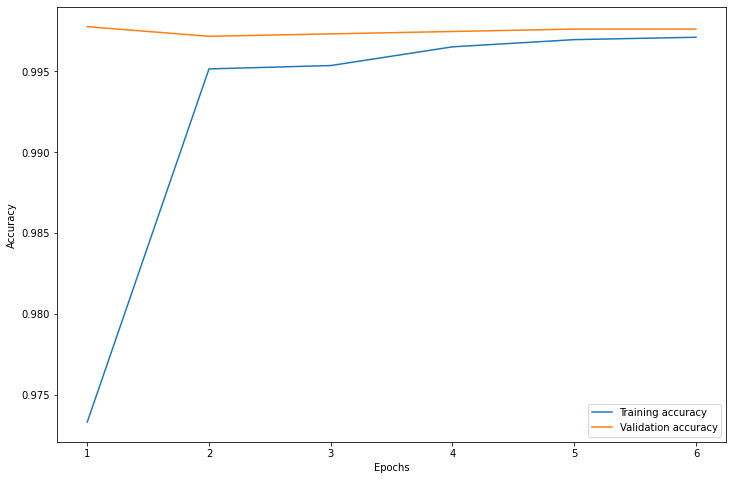

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12,8))
plt.title('Modelo más grande')
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)
train_loss, train_acc = model.evaluate(X_train, y_train)

1053/1053 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 0.9994
